**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import pandas as pd
from pandas import DataFrame

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
#%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def get_params(self, deep=False):
        obj = {'k_neighbors': self.k_neighbors,
               'algorithm': self.algorithm, 'metric': self.metric, 'p': self.p}
        return obj

    def Mink_distation(X, Y, p=2):
        n, k, m = Y.shape[0], Y.shape[1], X.shape[0]
        Y = np.reshape(Y, (1, k*n))
        Y = np.tile(Y, [m, 1])
        X = np.tile(X, [1, n])
        res = (np.abs(X-Y))**p
        res = np.reshape(res, (m*n, k))
        res = np.sum(res, axis=1)**(1/p)
        res = np.reshape(res, (m, n))
        return res

    def cosine_distation(X, Y):
        e_norm = X.dot(Y.T)
        Y_norm = np.linalg.norm(Y, axis=1)
        X_norm = np.linalg.norm(X, axis=1)
        res = 1 - e_norm/(X_norm.reshape((-1, 1))).dot(Y_norm.reshape((1, -1)))
        return res

    def __init__(self, k_neighbors, algorithm='brute',
                 metric='minkowski', p=2):
        self.k_neighbors = k_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.p = p

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = y
        self.classes = np.unique(y)
        return self

    def brute_alg(self, X):
        if self.metric == 'minkowski':
            dist_matrix = MyKNeighborsClassifier.Mink_distation(X, self.X)
        if self.metric == 'cosine':
            dist_matrix = MyKNeighborsClassifier.cosine_distation(X, self.X)
        k_nearest_ind = np.argpartition(dist_matrix,
                                        range(self.k_neighbors),
                                        axis=1)[:, 0:self.k_neighbors]
        uniq_y, count_uniq = np.unique(self.y[k_nearest_ind],
                                       axis=1, return_counts=True)
        prediction = uniq_y[:, np.argsort(count_uniq)][:, -1]
        return prediction

    def kd_alg(self, X):
        tree = KDTree(self.X)
        k_nearest_ind = tree.query(X, return_distance=False,
                                   k=self.k_neighbors+1)
        uniq_y, count_uniq = np.unique(self.y[k_nearest_ind],
                                       axis=1, return_counts=True)
        prediction = uniq_y[:, np.argsort(count_uniq)][:, -1]
        return prediction

    def predict(self, X):
        if self.algorithm == 'brute':
            return MyKNeighborsClassifier.brute_alg(self, X)
        if self.algorithm == 'kd_tree':
            return MyKNeighborsClassifier.kd_alg(self, X)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            dist_matrix = MyKNeighborsClassifier.Mink_distation(X, self.X)
            k_nearest_ind = np.argpartition(dist_matrix,
                                            range(self.k_neighbors),
                                            axis=1)[:, 0:self.k_neighbors]
        if self.algorithm == 'kd_tree':
            tree = KDTree(self.X)
            k_nearest_ind = tree.query(X, return_distance=False,
                                       k=self.k_neighbors+1)
        prediction_proba = np.zeros((X.shape[0], self.classes.shape[0]))
        for i in range(X.shape[0]):
            if self.algorithm == 'brute':
                uniq_y, count_uniq = np.unique(self.y[k_nearest_ind[i, :]],
                                               return_counts=True)
            if self.algorithm == 'kd_tree':
                uniq_y, count_uniq = np.unique(self.y[k_nearest_ind[i, 1:]],
                                               return_counts=True)
            uniq_y = uniq_y.astype(int)
            prediction_proba[i, uniq_y] = count_uniq/self.k_neighbors
        return prediction_proba

    def score(self, X, y):
        return np.mean(self.predict(X) == y)



**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target, test_size=0.1,
                                                    stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(k_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', k_neighbors=2, metric='minkowski',
                       p=2)

In [8]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [9]:
iris_frame = DataFrame(iris.data)
iris_frame.columns = iris.feature_names
iris_frame['target'] = iris.target
iris_frame['name'] = iris_frame.target.apply(lambda x : iris.target_names[x])
iris_frame.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
5,5.4,3.9,1.7,0.4,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
7,5.0,3.4,1.5,0.2,0,setosa
8,4.4,2.9,1.4,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa


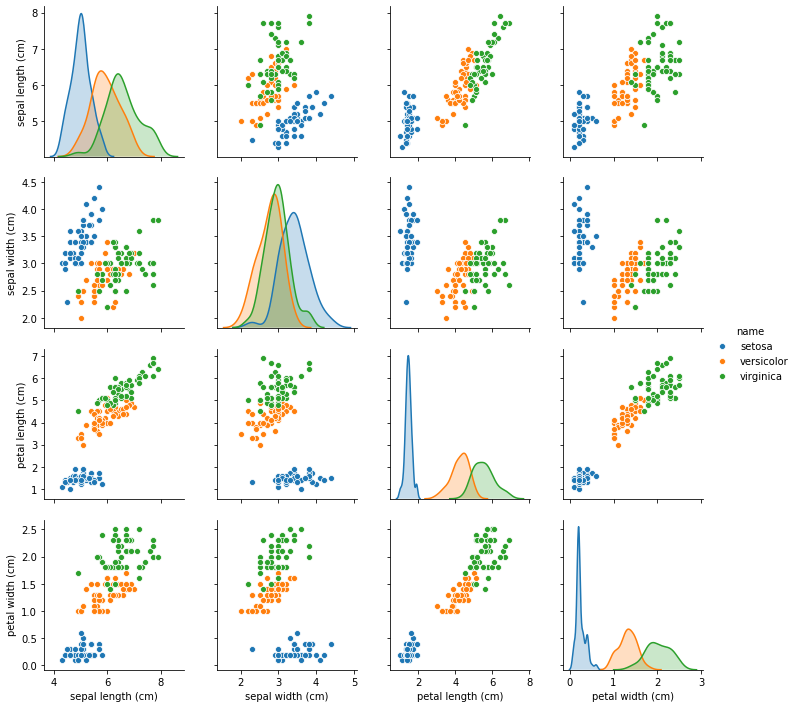

In [64]:
sns.pairplot(iris_frame[['sepal length (cm)',
                         'sepal width (cm)','petal length (cm)','petal width (cm)',
                         'name']], hue = 'name')

In [10]:
iris_frame[['sepal length (cm)','sepal width (cm)',
            'petal length (cm)','petal width (cm)']].corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


In [11]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [12]:
%time my_clf.fit(X_train, y_train)

Wall time: 992 µs


MyKNeighborsClassifier(algorithm='brute', k_neighbors=2, metric='minkowski',
                       p=2)

In [13]:
%%time 
clf.predict(X_test)

Wall time: 1.96 ms


array([2, 0, 1, 1, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 1])

In [14]:
%time my_clf.predict(X_test)

Wall time: 999 µs


array([2, 0, 1, 1, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 1])

In [15]:
%time clf.predict_proba(X_test)

Wall time: 999 µs


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [16]:
%time my_clf.predict_proba(X_test)

Wall time: 1.99 ms


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(k_neighbors=2, algorithm='kd_tree')

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target, test_size=0.1,
                                                    stratify=iris.target)

In [19]:
%time clf.fit(X_train, y_train)

Wall time: 997 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [20]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='kd_tree', k_neighbors=2, metric='minkowski',
                       p=2)

In [21]:
%time clf.predict(X_test)

Wall time: 2.96 ms


array([2, 2, 0, 1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0])

In [22]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([2, 2, 0, 1, 1, 2, 2, 0, 0, 2, 1, 1, 0, 1, 0])

In [23]:
%time clf.predict_proba(X_test)

Wall time: 1.01 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [24]:
%time my_clf.predict_proba(X_test)

Wall time: 2.99 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [25]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [3]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [4]:
data = newsgroups['data'][:1000]
target = newsgroups['target'][:1000]

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [5]:
import re

In [6]:
data_tok = [re.split("\W", data_str.lower()) for data_str in data]
data_tok = [[tok for tok in row if tok] for row in data_tok]
target = [target[i] for i in range(len(target)) if data_tok[i] != []]
target = np.array(target)
data_tok = [row for row in data_tok if row != []]

In [7]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vectorizer = CountVectorizer(min_df=10)
X = vectorizer.fit_transform([' '.join(row) for row in data_tok])

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [8]:
def kfold(n, n_folds):
    n_first = n % n_folds
    n_first_size = n // n_folds + 1
    other_size = n // n_folds
    res = []
    border = 0
    for _ in range(n_first):
        valid_idxs = np.arange(border, border + n_first_size)
        test_idxs = np.empty(n - n_first_size, dtype=int)
        test_idxs[:border] = np.arange(0, border)
        test_idxs[border:] = np.arange(border + n_first_size, n)
        border = border + n_first_size
        res.append((test_idxs, valid_idxs))

    for _ in range(n_first, n_folds):
        valid_idxs = np.arange(border, border + other_size)
        test_idxs = np.empty(n-other_size, dtype=int)
        test_idxs[:min(border, test_idxs.size)] = np.arange(
            min(border, test_idxs.size))
        test_idxs[border:] = np.arange(border + other_size, n)
        border = border + other_size
        res.append((test_idxs, valid_idxs))
    return res

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [9]:
from sklearn.model_selection import cross_val_score 

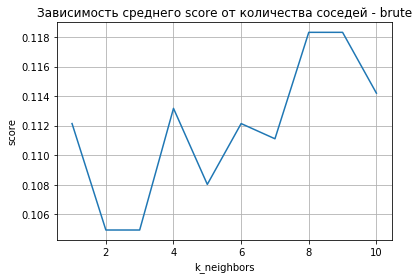

In [35]:
neighb_vector = np.array(range(1, 11))
mean_vector1 = np.zeros(10)
for i in range(10):
    clf1 = KNeighborsClassifier(n_neighbors=i+1, algorithm='brute')
    score_vector1 = cross_val_score(clf1, X, target, cv=kfold(X.shape[0], 3))
    mean_vector1[i] = np.mean(score_vector1)
plt.title("Зависимость среднего score от количества соседей - brute")
plt.xlabel("k_neighbors")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector1)

In [36]:
from sklearn.neighbors import DistanceMetric

C:\Users\karry\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


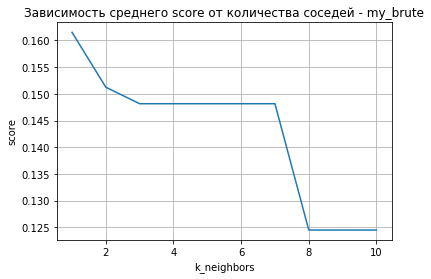

In [37]:
# X1 не помещается в опертивную память даже при взятии среза
# [:1000] и включении в матрицу X слов при условии min_df=10
X1 = X.todense()
neighb_vector = np.array(range(1, 11))
mean_vector = np.zeros(10)
kf = kfold(X.shape[0], 3)
for i in range(10):
    my_clf = MyKNeighborsClassifier(k_neighbors=i+1,
                                    algorithm='brute', metric='cosine')
    score_vector = cross_val_score(my_clf, X1, target, cv=kf)
    mean_vector[i] = np.mean(score_vector)
plt.title("Зависимость среднего score от количества соседей - my_brute")
plt.xlabel("k_neighbors")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

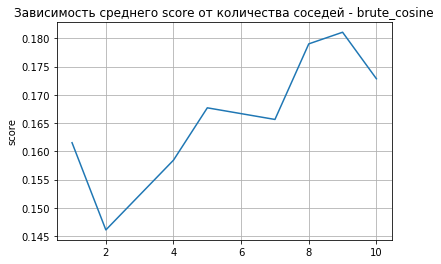

In [38]:
neighb_vector = np.array(range(1, 11))
mean_vector2 = np.zeros(10)
kf = kfold(X.shape[0], 3)
for i in range(10):
    clf2 = KNeighborsClassifier(n_neighbors=i+1,
                                algorithm='brute', metric='cosine')
    score_vector2 = cross_val_score(clf2, X, target, cv=kf)
    mean_vector2[i] = np.mean(score_vector2)
plt.title("Зависимость среднего score от количества соседей - brute_cosine")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector2)

In [39]:
from sklearn.neighbors import DistanceMetric

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Аналогично - не помещается в оперативную память

neighb_vector = np.array(range(1, 11))
mean_vector = np.zeros(10)
kf = kfold(X.shape[0], 3)
for i in range(10):
    my_clf = MyKNeighborsClassifier(k_neighbors=i+1,
                                    algorithm='brute', metric='cosine')
    score_vector = cross_val_score(my_clf, X, target, cv=kf)
    mean_vector[i] = np.mean(score_vector)
plt.title("Зависимость среднего score от количества соседей - my_brute_cosine")
plt.xlabel("k_neighbors")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector)

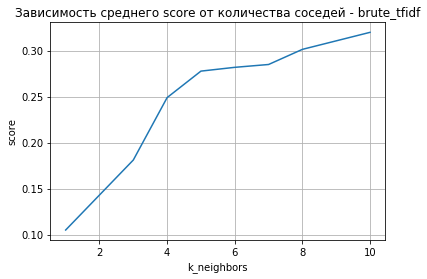

In [41]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)
neighb_vector = np.array(range(1, 11))
mean_vector2 = np.zeros(10)
kf = kfold(X.shape[0], 3)
for i in range(10):
    clf2 = KNeighborsClassifier(n_neighbors=i+1, algorithm='brute')
    score_vector2 = cross_val_score(clf2, X_tfidf, target, cv=kf)
    mean_vector2[i] = np.mean(score_vector2)
plt.title("Зависимость среднего score от количества соседей - brute_tfidf")
plt.xlabel("k_neighbors")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector2)

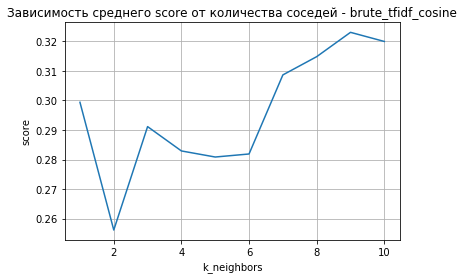

In [42]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)
neighb_vector = np.array(range(1, 11))
mean_vector2 = np.zeros(10)
kf = kfold(X.shape[0], 3)
for i in range(10):
    clf2 = KNeighborsClassifier(n_neighbors=i+1,
                                algorithm='brute', metric='cosine')
    score_vector2 = cross_val_score(clf2,
                                    X_tfidf, target, cv=kf)
    mean_vector2[i] = np.mean(score_vector2)
plt.title(
    "Зависимость среднего score от количества соседей - brute_tfidf_cosine")
plt.xlabel("k_neighbors")
plt.ylabel("score")
plt.grid()
plt.plot(neighb_vector, mean_vector2)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [9]:
newsgroups = fetch_20newsgroups(subset='test',
                                remove=['headers', 'footers', 'quotes'])
data_test = newsgroups['data'][:1000]
target_test = newsgroups['target'][:1000]

In [10]:
data_tok_test = [re.split("\W", data_str.lower()) for data_str in data_test]
data_tok_test = [[tok for tok in row if tok] for row in data_tok_test]
target_test = [target_test[i] for i in
               range(len(target_test)) if data_tok_test[i] != []]
target_test = np.array(target_test)
data_tok_test = [row for row in data_tok_test if row != []]

In [11]:
from scipy.sparse import csr_matrix

In [12]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
X = csr_matrix((data, indices, indptr), shape=(len(data_tok), 5000))
X.shape, len(target[:X.shape[0]])

((972, 5000), 972)

In [13]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok_test:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))
X_test = csr_matrix((data, indices, indptr), shape=(len(data_tok_test), 5000))
X_test.shape, len(target_test)

((979, 5000), 979)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_test)
# Это tfidf преобразование процессор на момент компиляции всего ДЗ не смог сделать -
# ядро juputer notebook прерывает работу, поэтому дальше вывести результаты не получилось
# пишу, что было получено при первых попытках компиляции

In [ ]:
kf = kfold(X_tfidf.shape[0], 3)
clf = KNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine')
score_vector = cross_val_score(clf, X_tfidf, target_test, cv=kf)
mean_vector = np.mean(score_vector)
mean_vector
# ~0.63
# На кросс-валидации получился результат намного лучше, чем выше. Возможно, потому что
# использовала другой алгоритм построения разреженной матрицы.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=9,
                           algorithm='brute', metric='cosine')
clf.fit(X, target)
clf.score(X_tfidf, target_test)
# ~0.20

In [ ]:
#И снова не получилось протестировать на своем алгоритме - компьютер зависает
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_test)
my_clf = MyKNeighborsClassifier(k_neighbors=9,
                                algorithm='brute', metric='cosine')
my_clf.fit(X, target)
my_clf.score(X_tfidf, target_test)